# Planning and Stock Report Generation

In [14]:
#Setup 
from dotenv import load_dotenv

import os

load_dotenv()
API_KEY = os.getenv("OPENAI_KEY")

In [15]:
llm_config = {"model": "gpt-4-turbo", "api_key": API_KEY}

What if we want agents to solve complex tasks without humans telling them what to do? For this, we can use the functionality of Autogen group chats.

In [16]:
task = "Write a blogpost about the stock price performance of "\
"Nvidia in the past month. Today's date is 2024-08-04."

## Build a group chat
This group chat will include these agents:

- User_proxy or Admin: to allow the user to comment on the report and ask the writer to refine it.

- Planner: to determine relevant information needed to complete the task.

- Engineer: to write code using the defined plan by the planner.

- Executor: to execute the code written by the engineer.

- Writer: to write the report.

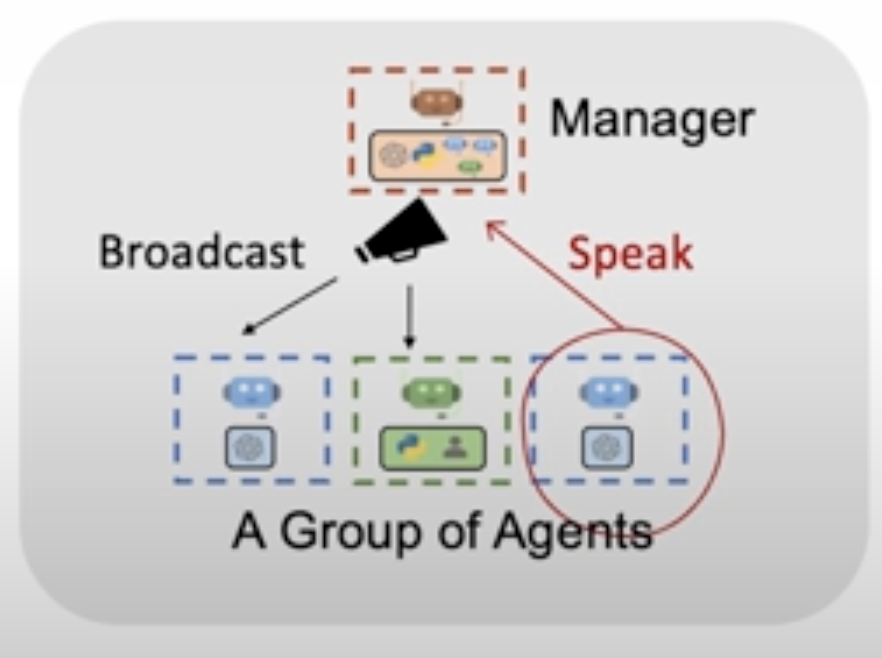

In [17]:
from IPython.display import Image

Image(filename='../assets/Group_chat.png', width=500)

In [18]:
import autogen

## Create the Agents

#### Proxy/Admin Agent

In [19]:
user_proxy = autogen.ConversableAgent(
    name="Admin",
    system_message="Give the task, and send "
    "instructions to writer to refine the blog post.",
    code_execution_config=False,
    llm_config=llm_config,
    human_input_mode="ALWAYS",
)

#### Planner:

In [20]:
planner = autogen.ConversableAgent(
    name="Planner",
    #System message is an instruction to the agent
    system_message="Given a task, please determine "
    "what information is needed to complete the task. "
    "Please note that the information will all be retrieved using"
    " Python code. Please only suggest information that can be "
    "retrieved using Python code. "
    "After each step is done by others, check the progress and "
    "instruct the remaining steps. If a step fails, try to "
    "workaround",
    #This is for letting other agents know the role of this agent
    description="Planner. Given a task, determine what "
    "information is needed to complete the task. "
    "After each step is done by others, check the progress and "
    "instruct the remaining steps",
    llm_config=llm_config,
)

### Engineer:

In [21]:
engineer = autogen.AssistantAgent( #It has a default system message for writing code
    name="Engineer",
    llm_config=llm_config,
    description="An engineer that writes code based on the plan "
    "provided by the planner.",
)

#### Executor:

In [22]:
executor = autogen.ConversableAgent(
    name="Executor",
    system_message="Execute the code written by the "
    "engineer and report the result.",
    human_input_mode="NEVER",
    code_execution_config={
        "last_n_messages": 3, #Look back on the conversation history 
        "work_dir": "coding",
        "use_docker": False,
    },
)

#### Writer:

In [23]:
writer = autogen.ConversableAgent(
    name="Writer",
    llm_config=llm_config,
    system_message="Writer."
    "Please write blogs in markdown format (with relevant titles)"
    " and put the content in pseudo ```md``` code block. "
    "You take feedback from the admin and refine your blog.",
    description="Writer."
    "Write blogs based on the code execution results and take "
    "feedback from the admin to refine the blog."
)

### Define Group Chat:

In [24]:
groupchat = autogen.GroupChat(
    agents=[user_proxy, engineer, writer, executor, planner],
    messages=[],
    max_round=10,
)

#### Create a Group Chat manager to manage the chat:

In [25]:
manager = autogen.GroupChatManager(
    groupchat=groupchat, llm_config=llm_config
)

### Start the chat

In [28]:
groupchat_result = user_proxy.initiate_chat(
    manager,
    message=task,
)

Admin (to chat_manager):

Write a blogpost about the stock price performance of Nvidia in the past month. Today's date is 2024-08-04.

--------------------------------------------------------------------------------

Next speaker: Planner


>>>>>>>> USING AUTO REPLY...
Planner (to chat_manager):

To write a blog post about Nvidia's stock price performance over the past month, including today's date which is August 4, 2024, we need to gather the following data:

1. Nvidia's daily stock prices from July 4, 2024, to August 4, 2024.
2. Any relevant corporate news or events related to Nvidia that may have influenced stock prices during this period.
3. General market trends or major economic events that could have impacted Nvidia's stock performance.

Now, let's break these down to steps on how to retrieve this information using Python:

### Step 1: Retrieve Nvidia's Daily Stock Prices
To get the historical stock prices, you can use financial APIs like Yahoo Finance or Alpha Vantage. Python 

Comunication between agents is not always happening as expected. Sometimes the writer starts writing without any supervision from the Planner.

### How to set more controls on the conversation:

Speaker selection policy:

In [29]:
user_proxy = autogen.ConversableAgent(
    name="Admin",
    system_message="Give the task, and send "
    "instructions to writer to refine the blog post.",
    code_execution_config=False,
    llm_config=llm_config,
    human_input_mode="ALWAYS",
)

planner = autogen.ConversableAgent(
    name="Planner",
    system_message="Given a task, please determine "
    "what information is needed to complete the task. "
    "Please note that the information will all be retrieved using"
    " Python code. Please only suggest information that can be "
    "retrieved using Python code. "
    "After each step is done by others, check the progress and "
    "instruct the remaining steps. If a step fails, try to "
    "workaround",
    description="Given a task, determine what "
    "information is needed to complete the task. "
    "After each step is done by others, check the progress and "
    "instruct the remaining steps",
    llm_config=llm_config,
)

engineer = autogen.AssistantAgent(
    name="Engineer",
    llm_config=llm_config,
    description="Write code based on the plan "
    "provided by the planner.",
)

writer = autogen.ConversableAgent(
    name="Writer",
    llm_config=llm_config,
    system_message="Writer. "
    "Please write blogs in markdown format (with relevant titles)"
    " and put the content in pseudo ```md``` code block. "
    "You take feedback from the admin and refine your blog.",
    description="After all the info is available, "
    "write blogs based on the code execution results and take "
    "feedback from the admin to refine the blog. ",
)

executor = autogen.ConversableAgent(
    name="Executor",
    description="Execute the code written by the "
    "engineer and report the result.",
    human_input_mode="NEVER",
    code_execution_config={
        "last_n_messages": 3,
        "work_dir": "coding",
        "use_docker": False,
    },
)

Constraints:

In [36]:
groupchat = autogen.GroupChat(
    agents=[user_proxy, engineer, writer, executor, planner],
    messages=[],
    max_round=20, #For each agent which agent is allowed to speak after this specific agent
    allowed_or_disallowed_speaker_transitions={
        user_proxy: [engineer, writer, executor, planner],
        engineer: [user_proxy, executor],
        writer: [user_proxy, planner],
        executor: [user_proxy, engineer, planner],
        planner: [user_proxy, engineer, writer],
    },
    speaker_transitions_type="allowed",
)

In [37]:
manager = autogen.GroupChatManager(
    groupchat=groupchat, llm_config=llm_config
)

groupchat_result = user_proxy.initiate_chat(
    manager,
    message=task,
)

Admin (to chat_manager):

Write a blogpost about the stock price performance of Nvidia in the past month. Today's date is 2024-08-04.

--------------------------------------------------------------------------------

Next speaker: Planner


>>>>>>>> USING AUTO REPLY...
Planner (to chat_manager):

To write a blog post about the stock price performance of Nvidia for the past month, you will need to gather the following information using Python code:

1. **Stock Prices for Nvidia for the Past Month**: You will need the daily closing prices (and possibly the opening, high, and low prices) for Nvidia for the last month.

2. **Comparison Data (Optional)**: It might be useful to compare Nvidia’s performance with other similar companies in the same sector, or with broader stock market indices like the S&P 500, during the same time period.

3. **Significant Events or News**: Any major events or news related to Nvidia that might have impacted stock prices during the past month.

Here's how Pytho

Natural language options can be added to the agents’ descriptions to further enhance transitions. Transition order can also be specified.